<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/GP_Augmentation_OVPGrass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Try again with data from a single acquisition

Loading drive

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing packages

In [125]:
#General purpose: 
#plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data management
import pandas as pd
import numpy
import numpy as np

#Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, ExpSineSquared, RationalQuadratic, RBF, DotProduct

#model evaluation from sklearn
from sklearn import metrics

#a few more stuff for random
import random as rdm
import math

Loading the csv file

In [142]:
#filepath="/content/drive/My Drive/Leon/Leon_Data_Montesinho.csv"
filepath="/content/drive/My Drive/OVP_Grass/Table_data/Vincent/input_data.csv"
filepath2="/content/drive/My Drive/OVP_Grass/Table_data/Vincent/input_data_2017.csv"

#for portuguese type CSV
#field_data = pd.read_csv(filepath,sep=";",decimal=",")
#for other types
#field_data = pd.read_csv(filepath,sep=",",decimal=".")
field_data = pd.read_csv(filepath2,sep=";",decimal=",")
field_data

,Date,Plot,Afstand,NDVI,EVI,RATIO,SAVI,TVI,NDWI,NDTI,RDVI,BLUE,GREEN,RED,NIR,MIR,SWIR2,Grass height,Grass cover
0,42900,E32,400,0.690485,2.553107,5.461717,1.035170,1.091093,0.358338,0.326573,21.038078,136.000000,189.500000,143.666667,784.666667,370.666667,188.166667,2.989169,1.00
1,43040,E32,450,0.785399,2.265445,8.319608,1.177603,1.133754,0.299939,0.325022,27.073480,106.250000,169.250000,127.500000,1060.750000,571.250000,291.000000,8.018575,1.00
2,43040,E29,150,0.722375,1.828155,6.203971,1.082343,1.105611,0.225749,0.325802,15.211867,41.888889,69.888889,61.555556,381.888889,241.222222,122.666667,5.096286,0.90
3,42900,C29,420,0.728079,1.849383,6.355082,1.091813,1.108187,0.335306,0.326804,30.759371,165.666667,335.333333,242.666667,1542.166667,767.666667,389.500000,4.015550,1.00
4,43040,E30,500,0.774029,2.244753,7.850688,1.160271,1.128729,0.283855,0.337133,21.209426,70.500000,104.500000,84.833333,666.000000,371.500000,184.166667,5.188388,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,43040,E32,250,0.774622,2.463827,7.873975,1.161329,1.128992,0.295188,0.385227,24.029931,99.888889,139.777778,108.444444,853.888889,464.666667,206.222222,4.839608,0.95
273,42900,E139,300,0.700287,2.456869,5.673054,1.049865,1.095576,0.375635,0.333333,21.340573,128.500000,184.666667,139.166667,789.500000,358.333333,179.166667,4.937594,1.00
274,43040,E32,400,0.766371,2.531752,7.560579,1.148828,1.125331,0.315814,0.349891,21.526703,87.166667,104.666667,92.166667,696.833333,362.333333,174.500000,3.956264,1.00
275,42900,E31,450,0.690527,2.462535,5.462601,1.035238,1.091113,0.368998,0.331305,21.126066,134.000000,188.333333,144.833333,791.166667,364.666667,183.166667,3.026039,0.95


Removing NA values

In [146]:
corr_df = field_data.dropna()
print(field_data.shape)
print(corr_df.shape)

field_data=corr_df


(277, 19)
(277, 19)


Selecting target and explanatory variables

In [147]:
tgt_trait= "Grass height"
tgt_trait_2 = "Grass cover"

#selecting the trait and indices only
sel_df = field_data[[tgt_trait,tgt_trait_2,
                     "NDVI","EVI","RATIO",
                     "SAVI","TVI","NDWI",
                     "NDTI","RDVI","BLUE",
                     "GREEN","RED","NIR",
                     "MIR","SWIR2"]]
                  
#sel_df


Exploring the data 

Text(0, 0.5, 'NDWI')

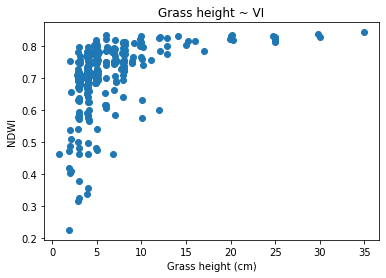

In [148]:
plt.scatter(sel_df[[tgt_trait]], sel_df[["NDVI"]])
plt.title("Grass height ~ VI")
plt.xlabel("Grass height (cm)")
plt.ylabel("NDWI")

Creating a 70/30 partition - NOT K-fold validation

In [149]:
#generating an index to randomly select n rows. 
index = list(range(len(sel_df)))
index30 = rdm.sample(index,math.ceil(len(index)*.3)) #randomly selects 10% of te data (aproximately)
index70 = [x for x in index if x not in index30] #makes a list with the remaining
#index90
#index10

#subsetting the pd frames
tr_df = sel_df.iloc[index70,:]
vl_df = sel_df.iloc[index30,:]

#listing all items
feat_names = list(sel_df.columns)[2:]
tgt_names = list(sel_df.columns)[:2]

Generating a GP model call that is customizable. This helps to create more lean loops but is somewhat unecessary.

In [191]:
#gaussian processes with default acquisition function
#initializing the gaussian process -optimized
K_ratQ = RationalQuadratic(length_scale_bounds="fixed",alpha_bounds="fixed")
K_RBF = RBF(length_scale_bounds="fixed")
#special kernel

#Check: Gaussian processes uncertainty estimates in experimental Sentinel-2 LAI and leaf chlorophyll content retrieval
#and Retrieval of Vegetation Biophysical Parameters Using Gaussian Process Techniques
#a scaling component can be added to the GPR which can be optimized in a loop - this case it is arbitrary

#K_scaledRBF = .5 * RBF(length_scale_bounds="fixed")
#K_scaledRBF = .001*RBF(length_scale_bounds="fixed")
#K_scaledRBF = np.var(vl_tgt_np[:,0])*RBF(length_scale_bounds="fixed")

K_DotP = DotProduct(sigma_0_bounds="fixed")

def gpr_call():
  mdl = GaussianProcessRegressor(kernel=K_RBF,
                                 n_restarts_optimizer=80, # -> 1*RBF(1.0) is the default kernel
                                 normalize_y=True,
                                 alpha=.05)
#with 0 alpha, crazy results

                                 #alpha=.001)
                                 #alpha=.05)
  return mdl
  

Looping

In [184]:
feat_names[0]

'NDVI'

------------------------------------------------------------
Trained using: NDVI
MAE hgt: 2.7177280319470873


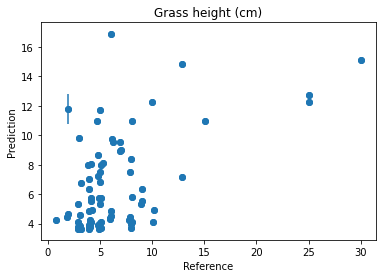

MAE cvr: 0.05319386498720272


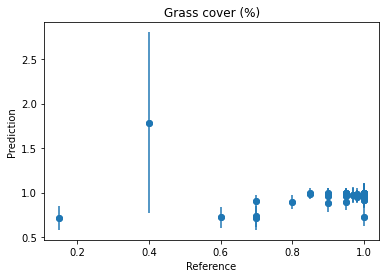

------------------------------------------------------------
------------------------------------------------------------
Trained using: EVI
MAE hgt: 2.442137889482127


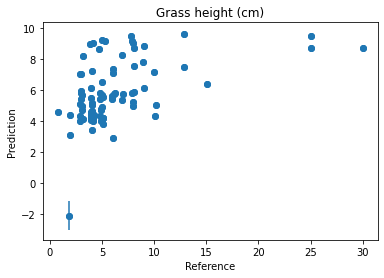

MAE cvr: 0.061156360486768306


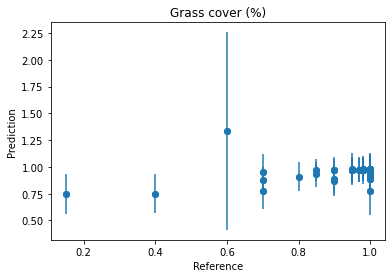

------------------------------------------------------------
------------------------------------------------------------
Trained using: RATIO
MAE hgt: 2.7889938315374385


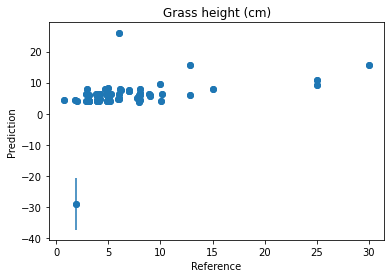

MAE cvr: 0.05761025233530588


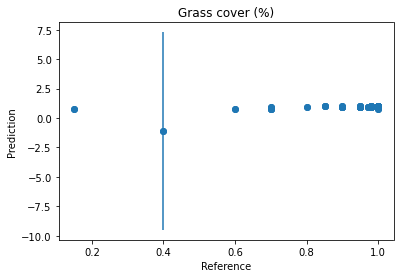

------------------------------------------------------------


KeyboardInterrupt: ignored

In [190]:

#making a numpy of the target variables (validation)
vl_tgt_df = vl_df[[tgt_trait,tgt_trait_2]]
vl_tgt_np = vl_tgt_df.iloc[:,:].values

#making a numpy of the target variables (training)
tr_tgt_df = tr_df[[tgt_trait,tgt_trait_2]]
tr_tgt_np = tr_tgt_df.iloc[:,:].values

for i in feat_names:

  #selecting the feature used for fitting
  var_tmp_df = tr_df[[i]]

  #tranforming to numpy array
  var_tmp_np = var_tmp_df.iloc[:,:].values
  
  #initating the GP
  gpr_mdl = gpr_call()

  #training the GPR
  gpr_mdl.fit(var_tmp_np,tr_tgt_np) #trains on ith variable against the training targets

  #selecting feature on the validation dataset and transforming to numpy 
  vl_var_df = vl_df[[i]]
  vl_var_np = vl_var_df.iloc[:,:].values

  #predicting against the validation data
  pred,sigma = gpr_mdl.predict(vl_var_np,return_std=True) #predicts on the validation dataset

  #the first column is height while the second is cover
  mae_hgt = metrics.mean_absolute_error(vl_tgt_np[:,0], pred[:,0])
  mae_cvr = metrics.mean_absolute_error(vl_tgt_np[:,1], pred[:,1])

  #dumping the outputs to the console
  print("------------------------------------------------------------")
  print("Trained using:",i)
  print("MAE hgt:",mae_hgt)
  #plotting height scatterplot
  plt.scatter(vl_tgt_np[:,0], pred[:,0])
  plt.errorbar(vl_tgt_np[:,0],pred[:,0],yerr=1.96*sigma,fmt='o')
  plt.title("Grass height (cm)")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")

  # R = np.corrcoef(vl_tgt_np[:,0],pred[:,0])
  # P = np.polyfit(vl_tgt_np[:,0],pred[:,0],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,0]), np.min(pred[:,0])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,0]), np.max(pred[:,0])])
  plt.show()

  print("MAE cvr:",mae_cvr)

  plt.scatter(vl_tgt_np[:,1], pred[:,1])
  plt.errorbar(vl_tgt_np[:,1],pred[:,1],yerr=1.96*sigma,fmt='o')
  plt.title("Grass cover (%)")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")
  
  # R = np.corrcoef(vl_tgt_np[:,1],pred[:,1])
  # P = np.polyfit(vl_tgt_np[:,1],pred[:,1],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,1]), np.min(pred[:,1])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,1]), np.max(pred[:,1])])
  plt.show()
  print("------------------------------------------------------------")


 


Same as above but single target instead of multi target

------------------------------------------------------------
Trained using: NDVI
MAE hgt: 3.992143941670543


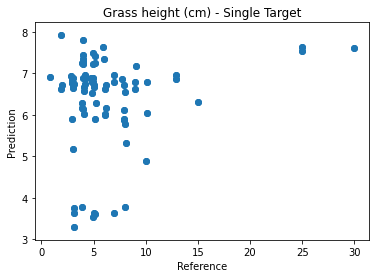

MAE cvr: 7.3501948558888515


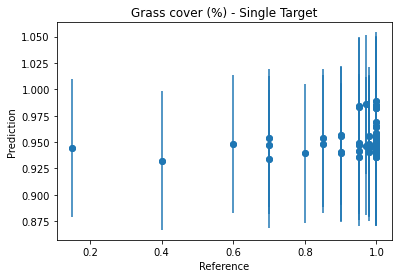

------------------------------------------------------------
------------------------------------------------------------
Trained using: EVI
MAE hgt: 3.9822437805642785


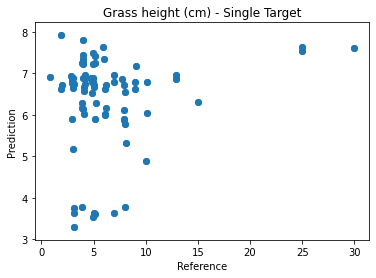

MAE cvr: 7.336486071390172


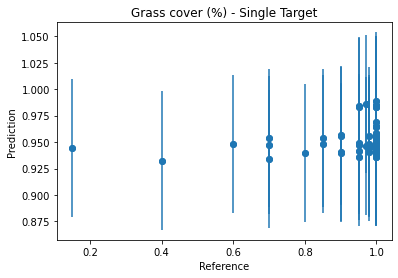

------------------------------------------------------------
------------------------------------------------------------
Trained using: RATIO
MAE hgt: 3.9588796853951775


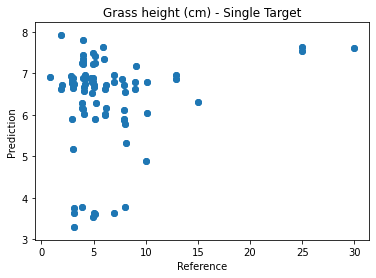

MAE cvr: 7.298174199425948


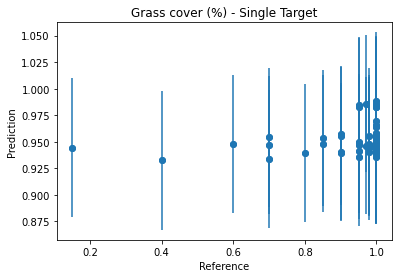

------------------------------------------------------------
------------------------------------------------------------
Trained using: SAVI
MAE hgt: 3.989993719740732


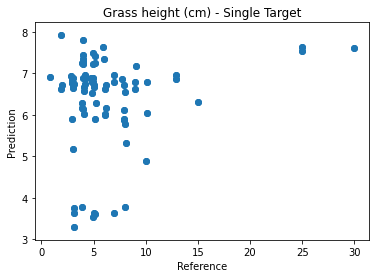

MAE cvr: 7.3470840264267325


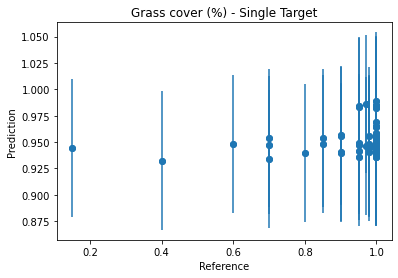

------------------------------------------------------------
------------------------------------------------------------
Trained using: TVI
MAE hgt: 3.989681662353666


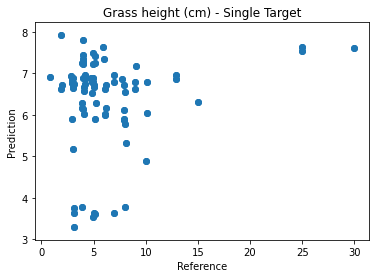

MAE cvr: 7.346856154851596


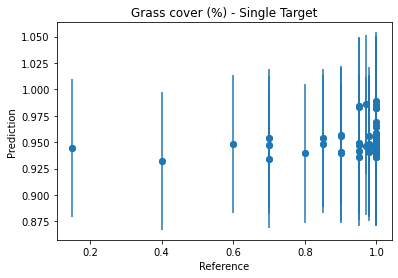

------------------------------------------------------------
------------------------------------------------------------
Trained using: NDWI
MAE hgt: 3.994726760991411


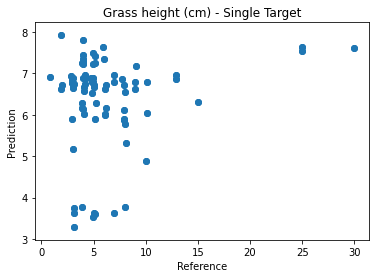

MAE cvr: 7.3537345246721095


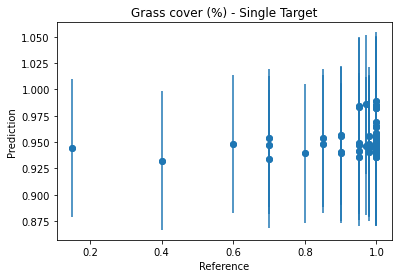

------------------------------------------------------------
------------------------------------------------------------
Trained using: NDTI
MAE hgt: 3.994396096516379


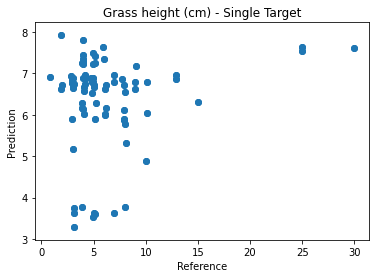

MAE cvr: 7.353417268292542


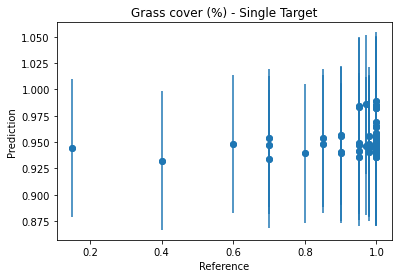

------------------------------------------------------------
------------------------------------------------------------
Trained using: RDVI
MAE hgt: 3.8610243566586795


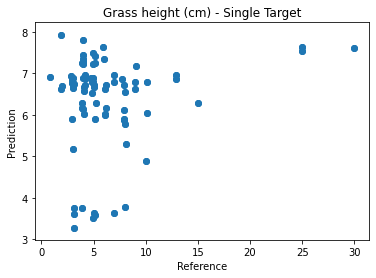

MAE cvr: 7.1589720868330335


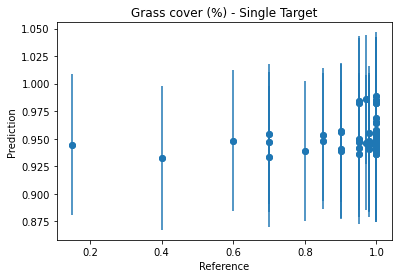

------------------------------------------------------------
------------------------------------------------------------
Trained using: BLUE
MAE hgt: 3.3817454233844466


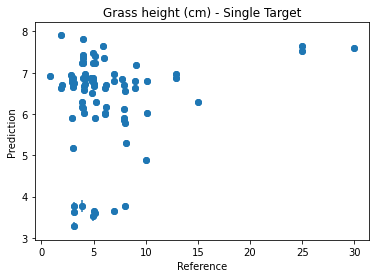

MAE cvr: 6.2861286578458975


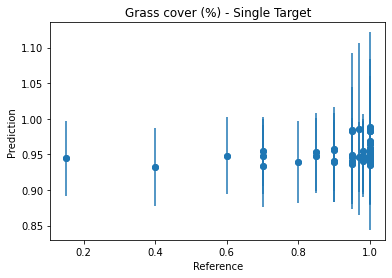

------------------------------------------------------------
------------------------------------------------------------
Trained using: GREEN
MAE hgt: 3.2180080221494


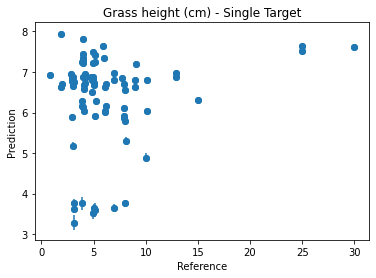

MAE cvr: 5.781896282576183


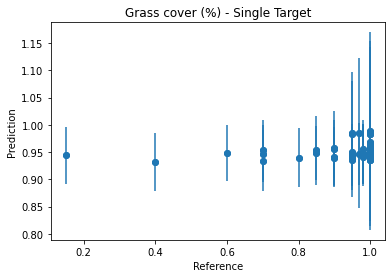

------------------------------------------------------------
------------------------------------------------------------
Trained using: RED
MAE hgt: 3.3196177771732764


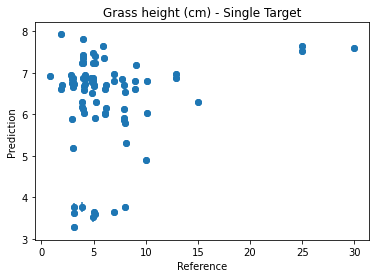

MAE cvr: 6.132391294786358


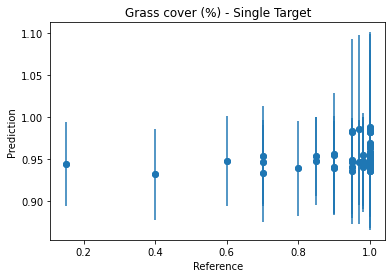

------------------------------------------------------------
------------------------------------------------------------
Trained using: NIR
MAE hgt: 6.452337280447561


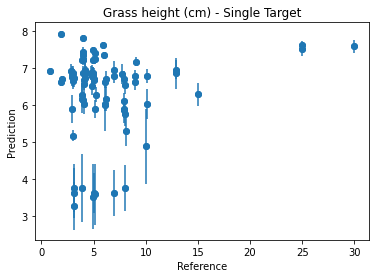

MAE cvr: 3.4746428126446616


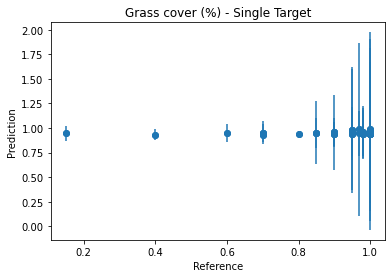

------------------------------------------------------------
------------------------------------------------------------
Trained using: MIR
MAE hgt: 3.529169642874249


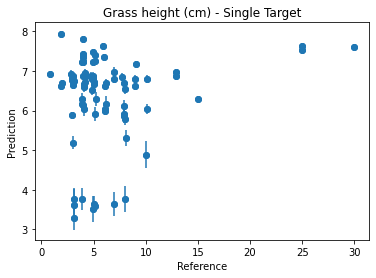

MAE cvr: 3.9021787630013756


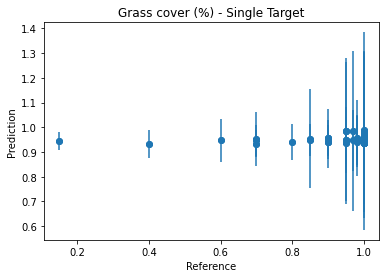

------------------------------------------------------------
------------------------------------------------------------
Trained using: SWIR2
MAE hgt: 3.146023583751805


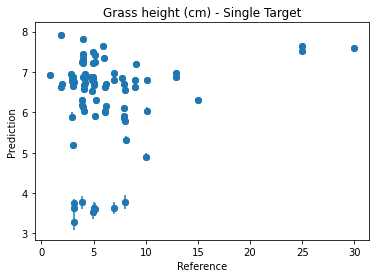

MAE cvr: 5.428010978524289


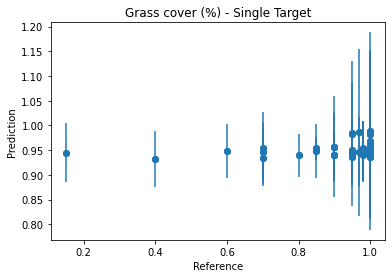

------------------------------------------------------------


In [163]:
#making a numpy of the target variables (validation)
vl_tgt_df = vl_df[[tgt_trait,tgt_trait_2]]
vl_tgt_np = vl_tgt_df.iloc[:,:].values

#making a numpy of the target variables (training)
tr_tgt_df = tr_df[[tgt_trait,tgt_trait_2]]
tr_tgt_np = tr_tgt_df.iloc[:,:].values

for i in feat_names:

  #selecting the feature used for fitting
  var_tmp_df = tr_df[[i]]

  #tranforming to numpy array
  var_tmp_np = var_tmp_df.iloc[:,:].values
  
  #initating the GP
  gpr_mdl_hgt = gpr_call()
  gpr_mdl_cvc = gpr_call()

  #training the GPR
  gpr_mdl_hgt.fit(var_tmp_np,tr_tgt_np[:,0]) #trains on ith variable against the training targets
  gpr_mdl_cvc.fit(var_tmp_np,tr_tgt_np[:,1])

  #selecting feature on the validation dataset and transforming to numpy 
  vl_var_df = vl_df[[i]]
  vl_var_np = vl_var_df.iloc[:,:].values

  #predicting against the validation data
  pred1,sigma = gpr_mdl.predict(vl_var_np,return_std=True) #predicts on the validation dataset
  pred2,sigma = gpr_mdl.predict(vl_var_np,return_std=True) #predicts on the validation dataset

  #the first column is height while the second is cover
  mae_hgt = metrics.mean_absolute_error(vl_tgt_np[:,0], pred1[:,0])
  mae_cvr = metrics.mean_absolute_error(vl_tgt_np[:,1], pred2[:,0])

  #dumping the outputs to the console
  print("------------------------------------------------------------")
  print("Trained using:",i)
  print("MAE hgt:",mae_hgt)
  #plotting height scatterplot
  plt.scatter(vl_tgt_np[:,0], pred[:,0])
  plt.errorbar(vl_tgt_np[:,0],pred[:,0],yerr=1.96*sigma,fmt='o')
  plt.title("Grass height (cm) - Single Target")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")

  # R = np.corrcoef(vl_tgt_np[:,0],pred[:,0])
  # P = np.polyfit(vl_tgt_np[:,0],pred[:,0],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,0]), np.min(pred[:,0])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,0]), np.max(pred[:,0])])
  plt.show()

  print("MAE cvr:",mae_cvr)

  plt.scatter(vl_tgt_np[:,1], pred[:,1])
  plt.errorbar(vl_tgt_np[:,1],pred[:,1],yerr=1.96*sigma,fmt='o')
  plt.title("Grass cover (%) - Single Target")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")
  
  # R = np.corrcoef(vl_tgt_np[:,1],pred[:,1])
  # P = np.polyfit(vl_tgt_np[:,1],pred[:,1],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,1]), np.min(pred[:,1])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,1]), np.max(pred[:,1])])
  plt.show()
  print("------------------------------------------------------------")


 


Combination of specific bands where i expect significant correlations

Multitarget
MAE height: 2.934253244911522
MAE height: 0.06971343968462562


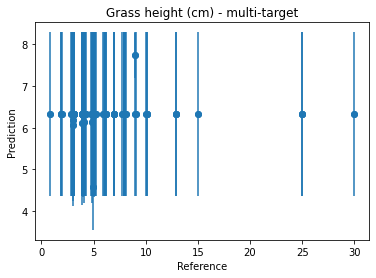

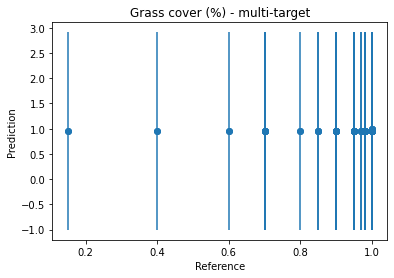

Single target
MAE height: 2.934253244911522
MAE height: 0.06971343968462562


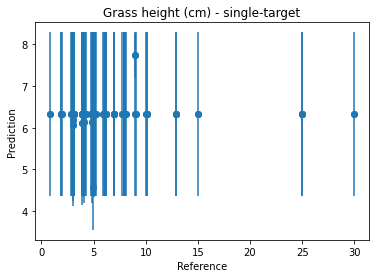

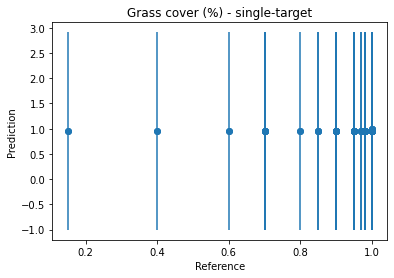

In [152]:
#Variable list for reference
# ["NDVI","EVI","RATIO",
#  "SAVI","TVI","NDWI",
#  "NDTI","RDVI","BLUE",
#  "GREEN","RED","NIR",
#  "MIR","SWIR2"]

#selecting the variables for training
sel_var_tmp_df = tr_df[["BLUE","GREEN","RED","NIR"]]
sel_var_tmp_np = sel_var_tmp_df.iloc[:,:].values

#selecting feature on the validation dataset and transforming to numpy 
sel_vl_var_df = vl_df[["BLUE","GREEN","RED","NIR"]]
sel_vl_var_np = sel_vl_var_df.iloc[:,:].values

#initiating the model object
sel_gpr_mdl = gpr_call()
sel_gpr_mdl_hgt = gpr_call()
sel_gpr_mdl_cvc = gpr_call()

#fitting multi-output
sel_gpr_mdl.fit(sel_var_tmp_np,tr_tgt_np)

#fitting single output
sel_gpr_mdl_hgt.fit(sel_var_tmp_np,tr_tgt_np[:,0])
sel_gpr_mdl_cvc.fit(sel_var_tmp_np,tr_tgt_np[:,1])

#making the predicitons
sel_pred,sel_sigma = sel_gpr_mdl.predict(sel_vl_var_np,return_std=True)
sel_pred_hgt,sel_sigma_hgt = sel_gpr_mdl_hgt.predict(sel_vl_var_np,return_std=True)
sel_pred_cvc,sel_sigma_cvc = sel_gpr_mdl_cvc.predict(sel_vl_var_np,return_std=True)

#error of multi-target
sel_mae_hgt = metrics.mean_absolute_error(vl_tgt_np[:,0], sel_pred[:,0])
sel_mae_cvc = metrics.mean_absolute_error(vl_tgt_np[:,1], sel_pred[:,1])

print("Multitarget")
print("MAE height:",sel_mae_hgt)
print("MAE height:",sel_mae_cvc)

plt.scatter(vl_tgt_np[:,0], sel_pred[:,0])
plt.errorbar(vl_tgt_np[:,0],sel_pred[:,0],yerr=1.96*sel_sigma,fmt='o')
plt.title("Grass height (cm) - multi-target")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.show()

plt.scatter(vl_tgt_np[:,1], sel_pred[:,1])
plt.errorbar(vl_tgt_np[:,1],sel_pred[:,1],yerr=1.96*sel_sigma,fmt='o')
plt.title("Grass cover (%) - multi-target")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.show()

#error of single target
sel_mae_hgt_st = metrics.mean_absolute_error(vl_tgt_np[:,0], sel_pred_hgt)
sel_mae_cvc_st = metrics.mean_absolute_error(vl_tgt_np[:,1], sel_pred_cvc)

print("Single target")
print("MAE height:",sel_mae_hgt_st)
print("MAE height:",sel_mae_cvc_st)

plt.scatter(vl_tgt_np[:,0], sel_pred_hgt)
plt.errorbar(vl_tgt_np[:,0],sel_pred_hgt,yerr=1.96*sel_sigma_hgt,fmt='o')
plt.title("Grass height (cm) - single-target")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.show()

plt.scatter(vl_tgt_np[:,1], sel_pred_cvc)
plt.errorbar(vl_tgt_np[:,1],sel_pred_cvc,yerr=1.96*sel_sigma_cvc,fmt='o')
plt.title("Grass cover (%) - single-target")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.show()




#Generating an example image from a landsat raster

In [ ]:
#loading needed packages
!pip install pyrsgis
!pip install rasterio
!pip install pyproj

import os
from pyrsgis import raster

import rasterio
import rasterio.plot
import pyproj
from pyrsgis.convert import changeDimension

In [153]:
ls_data_path = "/content/drive/My Drive/OVP_Grass/Image_data/Vincent/LC08_198023_20150702.tif"

#loading the raster and checking dimensions
ls1,bands = raster.read(ls_data_path)
print(ls1)
print(bands.shape) #the raster has 9 bands by 501 x 590 (not sure wich is the row)

#converting the rasters into a 2D array where the rows represent the pixel cells and the columns the bands
bandByPixel = changeDimension(bands)#/10000. #we have to devide all values by 10k - its a conversion from bits to reflectances
bandByPixel_t = np.transpose(bandByPixel)
print(bandByPixel.shape)
print(bandByPixel_t.shape)
bandByPixel


(7, 334, 393)
(131262, 7)
(7, 131262)


array([[ 625,  701,  907, ...,  211,   79,   52],
       [ 627,  700,  904, ...,  214,   81,   55],
       [ 630,  701,  909, ...,  211,   78,   56],
       ...,
       [ 599,  806, 1215, ..., 2772, 2346, 1984],
       [ 608,  803, 1190, ..., 2957, 2424, 1907],
       [ 446,  600,  969, ..., 3442, 2028, 1443]])

Text(0, 0.5, 'Row #')

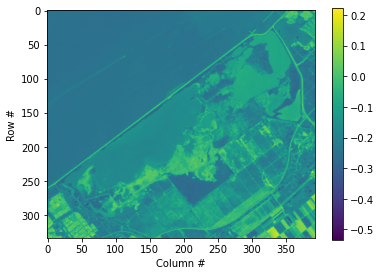

In [154]:
#plotting for exploration

#window = rasterio.windows.Window(1024, 1024, 1280, 2560)

#loads bands into a different object so they can be plotted or NDVI calculated
#notice it opens directly the raster so the division by 10k has to be done again
with rasterio.open(ls_data_path) as src:
  b4 = src.read(4)/10000.
with rasterio.open(ls_data_path) as src:
  b3 = src.read(3)/10000.   

#calculating NDVI
numpy.seterr(divide='ignore', invalid='ignore')
ndvi = (b4.astype(float) - b3.astype(float)) / (b4 + b3)
bandByPixel_ndvi = changeDimension(ndvi)

plt.figure(figsize=(6,8.5))
plt.imshow(ndvi)
#plt.clim(0,1)
plt.colorbar(shrink=0.5)
#plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

#Applying the GP to the data

Might be slow (or fail) if the raster is too big. 

In [158]:
#Predicting with the multiband model
sel_bands = bandByPixel[:,1:5] #selecting B, G, R, NIR
sel_bands.shape

out_img,out_std = sel_gpr_mdl.predict(sel_bands,return_std=True)

In [160]:
#Predicting with only the NDVI
#making a numpy of the target variables (validation)
vl_tgt_df = vl_df[[tgt_trait,tgt_trait_2]]
vl_tgt_np = vl_tgt_df.iloc[:,:].values

#making a numpy of the target variables (training)
tr_tgt_df = tr_df[[tgt_trait,tgt_trait_2]]
tr_tgt_np = tr_tgt_df.iloc[:,:].values

var_tmp_df = tr_df[["NDVI"]]
var_tmp_np = var_tmp_df.iloc[:,:].values

gpr_mdl = gpr_call()
gpr_mdl.fit(var_tmp_np,tr_tgt_np) #trains on ith variable against the training targets

#predicting
out_img,out_std = gpr_mdl.predict(bandByPixel_ndvi.reshape(-1, 1),return_std=True)

Converting back to a raster

Text(0, 0.5, 'Row #')

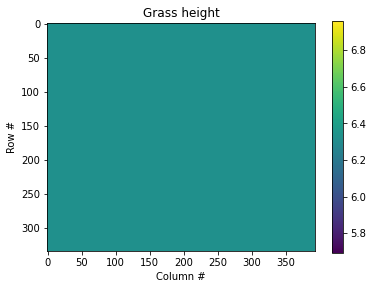

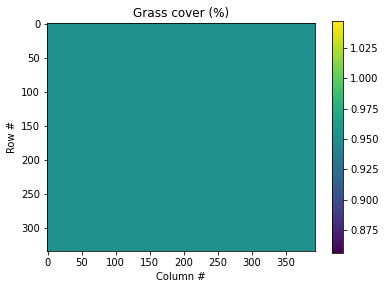

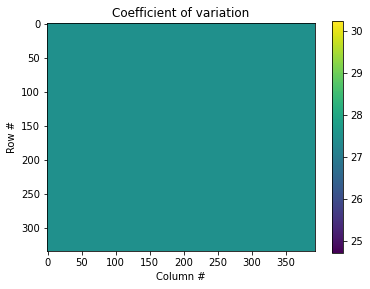

In [159]:
out_img_rst_hgt = np.reshape(out_img[:,0],(ls1.RasterYSize,ls1.RasterXSize))
out_img_rst_cvc = np.reshape(out_img[:,1],(ls1.RasterYSize,ls1.RasterXSize))
out_std_rst = np.reshape(out_std/np.mean(out_img)*100,(ls1.RasterYSize,ls1.RasterXSize))

#in a GIS we can easily change the color scale to avoid the extremes
plt.figure(figsize=(6,8.5))
plt.imshow(out_img_rst_hgt)
plt.colorbar(shrink=0.5)
#plt.clim(0,20)
plt.title('Grass height')
plt.xlabel('Column #')
plt.ylabel('Row #')

#in a GIS we can easily change the color scale to avoid the extremes
plt.figure(figsize=(6,8.5))
plt.imshow(out_img_rst_cvc)
#plt.clim(0,1)
plt.colorbar(shrink=0.5)
plt.title('Grass cover (%)')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.figure(figsize=(6,8.5))
plt.imshow(out_std_rst)
#plt.clim(0,20)
plt.colorbar(shrink=0.5)
plt.title('Coefficient of variation')
plt.xlabel('Column #')
plt.ylabel('Row #')

#saving the rasters to a temporary folder

In [ ]:
#raster.export(out_img_rst_hgt, ls1, "grass_height.tif", dtype='float')
raster.export(out_img_rst_cvc, ls1, "grass_cover.tif", dtype='float')